# Many-cell trajectory measurement


Designed to measure a series of time-dependent single-cell fluorescent/holographic intensities over the course of a time-lapse microscopy data set


```
Author: 
- Nathan J. Day (nathan.day.16@ucl.ac.uk)
```


### STEPS
1. Directory organisation
2. Load image information
3. Load the xyt data of each cell from HDF5 tracking file (see Arboretum tracker @quantumjot github)
4. Meta-analysis of tracks with optional filtering of anomalous tracks
5. Measure cellular properties across all images, all cells
6. Save information out as pandas df and .csv

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import ndimage
from skimage import io #used to be from skimage import io
from skimage.io import imshow
from sklearn import preprocessing
from matplotlib import animation
from natsort import natsorted
import btrack
from btrack.utils import import_HDF, import_JSON
from tqdm.notebook import tnrange, tqdm
from time import sleep
from pathlib import Path

## Measure 

Read cell mask information (location & area) and obtain fluorescent and phase stats. If the data already exists in a .csv and just needs to be plotted then skip to the plotter section.

#### Raw data (image) location

The image data needs to be organised inside the ```root_dir``` as follows:

```
phase/
    0000_phase.tif
    0001_phase.tif
    ...
gfp/
    0000_gfp.tif
    0001_gfp.tif
    ...
rfp/
    0000_rfp.tif
    0001_rfp.tif
    ...
labels/
    0000_mask.tif
    0001_mask.tif
    ...    
```

In [5]:
root_path = "/home/nathan/data/kraken/fucci/2017_10_18/pos16"
#root_path = "/home/nathan/data/SHARC/fucci/fucci1_171201/"

gfp_dir = os.path.join(root_path, "gfp")
rfp_dir = os.path.join(root_path, "rfp")
#phase_dir = os.path.join(root_path, "phase")
mask_dir = os.path.join(root_path, "labels")

gfp_list = natsorted([m for m in os.listdir(gfp_dir) if m.endswith('.tif')])
rfp_list = natsorted([m for m in os.listdir(rfp_dir) if m.endswith('.tif')])
#phase_list = natsorted([m for m in os.listdir(phase_dir) if m.endswith('.tif')])
mask_list = natsorted([m for m in os.listdir(mask_dir) if m.endswith('.tif')])

### Load the tracking information to obtain xyt of cells

Load tracks directly from hdf5

In [6]:
filename ='/home/nathan/data/kraken/fucci/2017_10_18/pos16/tracks/cellpose_nuclear_3.h5'
with btrack.dataio.HDF5FileHandler(filename, 'r') as h:
    tracks = h.tracks
tracks = (tracks[0]) #initially, tracks[0] is the tracks for cell type 0 (ie, WT or Scr etc)
print("Track information loaded")

[INFO][2020/08/25 07:43:39 PM] Opening HDF file: /home/nathan/data/kraken/fucci/2017_10_18/pos16/tracks/cellpose_nuclear_3.h5
[INFO][2020/08/25 07:43:39 PM] Loading tracks: obj_type_1...
[INFO][2020/08/25 07:43:39 PM] Loading obj_type_1 (398530, 5) (398530 filtered: None)...
[INFO][2020/08/25 07:43:46 PM] Closing HDF file: /home/nathan/data/kraken/fucci/2017_10_18/pos16/tracks/cellpose_nuclear_3.h5


Track information loaded


## Meta-analysis of tracks

List of track lengths

In [7]:
### length of tracks 
for i in range(len(tracks)):
    print("track ID.", tracks[i].ID,"length=", len(tracks[i]))

track ID. 75 length= 311
track ID. 89 length= 92
track ID. 88 length= 104
track ID. 87 length= 13
track ID. 86 length= 96
track ID. 85 length= 124
track ID. 84 length= 1257
track ID. 83 length= 384
track ID. 82 length= 70
track ID. 81 length= 260
track ID. 80 length= 279
track ID. 79 length= 8
track ID. 78 length= 9
track ID. 77 length= 269
track ID. 76 length= 322
track ID. 90 length= 348
track ID. 74 length= 273
track ID. 73 length= 292
track ID. 72 length= 323
track ID. 71 length= 358
track ID. 70 length= 30
track ID. 69 length= 253
track ID. 68 length= 311
track ID. 67 length= 334
track ID. 66 length= 411
track ID. 65 length= 58
track ID. 64 length= 428
track ID. 63 length= 284
track ID. 62 length= 396
track ID. 61 length= 269
track ID. 104 length= 1367
track ID. 1 length= 320
track ID. 117 length= 4
track ID. 116 length= 16
track ID. 115 length= 309
track ID. 114 length= 265
track ID. 113 length= 251
track ID. 112 length= 12
track ID. 111 length= 30
track ID. 110 length= 11
track 

track ID. 1628 length= 3
track ID. 1629 length= 101
track ID. 1630 length= 4
track ID. 1631 length= 1
track ID. 1632 length= 1
track ID. 1633 length= 1
track ID. 1635 length= 8
track ID. 1636 length= 1
track ID. 1637 length= 16
track ID. 1638 length= 172
track ID. 1642 length= 3
track ID. 1641 length= 53
track ID. 1639 length= 1
track ID. 1640 length= 7
track ID. 1643 length= 12
track ID. 1644 length= 1
track ID. 1645 length= 35
track ID. 1646 length= 47
track ID. 1647 length= 13
track ID. 1648 length= 2
track ID. 1670 length= 119
track ID. 1660 length= 11
track ID. 1661 length= 44
track ID. 1662 length= 1
track ID. 1664 length= 4
track ID. 1665 length= 30
track ID. 1666 length= 4
track ID. 1667 length= 41
track ID. 1668 length= 1
track ID. 1669 length= 54
track ID. 1663 length= 4
track ID. 1658 length= 13
track ID. 1659 length= 8
track ID. 1650 length= 1
track ID. 1651 length= 4
track ID. 1652 length= 4
track ID. 1653 length= 6
track ID. 1654 length= 4
track ID. 1655 length= 5
track I

track ID. 2996 length= 1
track ID. 3009 length= 1
track ID. 3008 length= 23
track ID. 3007 length= 1
track ID. 3006 length= 1
track ID. 3004 length= 1
track ID. 3003 length= 1
track ID. 3002 length= 1
track ID. 3005 length= 8
track ID. 3018 length= 113
track ID. 3017 length= 1
track ID. 3016 length= 96
track ID. 3015 length= 1
track ID. 3014 length= 1
track ID. 3013 length= 1
track ID. 3012 length= 1
track ID. 3011 length= 1
track ID. 3010 length= 1
track ID. 3020 length= 1
track ID. 3021 length= 1
track ID. 3022 length= 202
track ID. 3023 length= 13
track ID. 3024 length= 2
track ID. 3025 length= 88
track ID. 3026 length= 3
track ID. 3027 length= 31
track ID. 3029 length= 92
track ID. 3033 length= 14
track ID. 3032 length= 1
track ID. 3030 length= 707
track ID. 3031 length= 2
track ID. 3028 length= 1
track ID. 3034 length= 55
track ID. 3056 length= 44
track ID. 3055 length= 8
track ID. 3054 length= 1
track ID. 3053 length= 128
track ID. 3052 length= 1
track ID. 3051 length= 1
track ID

track ID. 4100 length= 1
track ID. 4094 length= 49
track ID. 4232 length= 1
track ID. 4231 length= 1
track ID. 4230 length= 1
track ID. 4229 length= 1
track ID. 4228 length= 1
track ID. 4227 length= 1
track ID. 4226 length= 1
track ID. 4225 length= 1
track ID. 4224 length= 1
track ID. 4243 length= 1
track ID. 4223 length= 1
track ID. 4233 length= 1
track ID. 4234 length= 1
track ID. 4235 length= 1
track ID. 4236 length= 4
track ID. 4237 length= 1
track ID. 4238 length= 1
track ID. 4239 length= 1
track ID. 4240 length= 1
track ID. 4241 length= 1
track ID. 4242 length= 1
track ID. 4201 length= 1
track ID. 4212 length= 1
track ID. 4202 length= 1
track ID. 4203 length= 1
track ID. 4204 length= 1
track ID. 4205 length= 1
track ID. 4206 length= 1
track ID. 4207 length= 1
track ID. 4208 length= 1
track ID. 4209 length= 1
track ID. 4210 length= 1
track ID. 4211 length= 1
track ID. 4222 length= 1
track ID. 4213 length= 1
track ID. 4214 length= 1
track ID. 4215 length= 1
track ID. 4216 length= 1

track ID. 5116 length= 1
track ID. 5115 length= 1
track ID. 5114 length= 1
track ID. 5113 length= 1
track ID. 5112 length= 1
track ID. 5111 length= 100
track ID. 5110 length= 1
track ID. 5120 length= 1
track ID. 5121 length= 1
track ID. 5122 length= 1
track ID. 5123 length= 1
track ID. 5124 length= 1
track ID. 5125 length= 1
track ID. 5126 length= 1
track ID. 5127 length= 1
track ID. 5128 length= 184
track ID. 5129 length= 1
track ID. 5130 length= 1
track ID. 5108 length= 1
track ID. 5109 length= 1
track ID. 5089 length= 1
track ID. 5090 length= 228
track ID. 5091 length= 1
track ID. 5092 length= 1
track ID. 5093 length= 1
track ID. 5094 length= 1
track ID. 5095 length= 1
track ID. 5096 length= 1
track ID. 5097 length= 1
track ID. 5099 length= 1
track ID. 5107 length= 1
track ID. 5106 length= 1
track ID. 5105 length= 2
track ID. 5104 length= 1
track ID. 5103 length= 1
track ID. 5102 length= 1
track ID. 5101 length= 1
track ID. 5100 length= 1
track ID. 5098 length= 1
track ID. 5136 leng

track ID. 5862 length= 1
track ID. 5863 length= 1
track ID. 5864 length= 1
track ID. 5865 length= 1
track ID. 5866 length= 1
track ID. 5867 length= 1
track ID. 5868 length= 1
track ID. 5869 length= 1
track ID. 5870 length= 1
track ID. 5871 length= 1
track ID. 5840 length= 1
track ID. 5814 length= 1
track ID. 5815 length= 1
track ID. 5816 length= 526
track ID. 5817 length= 1
track ID. 5818 length= 1
track ID. 5819 length= 1
track ID. 5820 length= 172
track ID. 5821 length= 1
track ID. 5822 length= 1
track ID. 5823 length= 1
track ID. 5824 length= 1
track ID. 5825 length= 1
track ID. 5826 length= 1
track ID. 5828 length= 1
track ID. 5842 length= 1
track ID. 5839 length= 1
track ID. 5838 length= 2
track ID. 5837 length= 1
track ID. 5836 length= 1
track ID. 5835 length= 3
track ID. 5834 length= 1
track ID. 5833 length= 1
track ID. 5832 length= 1
track ID. 5831 length= 1
track ID. 5830 length= 1
track ID. 5829 length= 1
track ID. 5827 length= 1
track ID. 5884 length= 1
track ID. 5883 length

track ID. 6693 length= 447
track ID. 6692 length= 12
track ID. 6689 length= 1
track ID. 6688 length= 9
track ID. 6687 length= 224
track ID. 6686 length= 3
track ID. 6685 length= 11
track ID. 6684 length= 440
track ID. 6683 length= 17
track ID. 6704 length= 1
track ID. 6711 length= 111
track ID. 6710 length= 184
track ID. 6708 length= 10
track ID. 6707 length= 1
track ID. 6705 length= 6
track ID. 6703 length= 244
track ID. 6702 length= 1
track ID. 6696 length= 1
track ID. 6697 length= 8
track ID. 6698 length= 1
track ID. 6700 length= 2
track ID. 6701 length= 173
track ID. 6699 length= 1
track ID. 6712 length= 1
track ID. 6713 length= 445
track ID. 6714 length= 1
track ID. 6715 length= 1
track ID. 6717 length= 4
track ID. 6721 length= 347
track ID. 6724 length= 120
track ID. 6723 length= 6
track ID. 6722 length= 1
track ID. 6720 length= 1
track ID. 6725 length= 119
track ID. 6726 length= 4
track ID. 6727 length= 1
track ID. 6728 length= 42
track ID. 6734 length= 258
track ID. 6729 length

track ID. 7724 length= 17
track ID. 7719 length= 357
track ID. 7726 length= 29
track ID. 7740 length= 6
track ID. 7747 length= 91
track ID. 7746 length= 4
track ID. 7745 length= 10
track ID. 7744 length= 1
track ID. 7743 length= 4
track ID. 7742 length= 2
track ID. 7741 length= 111
track ID. 7739 length= 15
track ID. 7736 length= 2
track ID. 7735 length= 1
track ID. 7734 length= 129
track ID. 7733 length= 5
track ID. 7732 length= 108
track ID. 7731 length= 41
track ID. 7748 length= 1
track ID. 7754 length= 1
track ID. 7753 length= 6
track ID. 7750 length= 355
track ID. 7749 length= 9
track ID. 7752 length= 3
track ID. 7760 length= 1
track ID. 7763 length= 2
track ID. 7762 length= 4
track ID. 7761 length= 1
track ID. 7759 length= 14
track ID. 7758 length= 39
track ID. 7757 length= 3
track ID. 7756 length= 23
track ID. 7755 length= 10
track ID. 7767 length= 1
track ID. 7773 length= 2
track ID. 7772 length= 2
track ID. 7771 length= 75
track ID. 7770 length= 353
track ID. 7768 length= 1
tr

track ID. 8770 length= 1
track ID. 8769 length= 39
track ID. 8768 length= 57
track ID. 8767 length= 276
track ID. 8765 length= 1
track ID. 8763 length= 40
track ID. 8759 length= 2
track ID. 8758 length= 61
track ID. 8756 length= 276
track ID. 8755 length= 1
track ID. 8754 length= 5
track ID. 8764 length= 1
track ID. 8775 length= 17
track ID. 8780 length= 5
track ID. 8779 length= 1
track ID. 8778 length= 3
track ID. 8776 length= 21
track ID. 8774 length= 1
track ID. 8773 length= 2
track ID. 8795 length= 16
track ID. 8794 length= 5
track ID. 8792 length= 2
track ID. 8788 length= 9
track ID. 8791 length= 24
track ID. 8789 length= 2
track ID. 8787 length= 56
track ID. 8786 length= 15
track ID. 8785 length= 2
track ID. 8790 length= 7
track ID. 8804 length= 38
track ID. 8806 length= 1
track ID. 8805 length= 79
track ID. 8800 length= 257
track ID. 8798 length= 23
track ID. 8796 length= 157
track ID. 8818 length= 85
track ID. 8820 length= 1
track ID. 8819 length= 271
track ID. 8817 length= 3
t

track ID. 9964 length= 11
track ID. 9973 length= 1
track ID. 9975 length= 3
track ID. 9974 length= 59
track ID. 9972 length= 7
track ID. 9971 length= 2
track ID. 9970 length= 2
track ID. 9969 length= 1
track ID. 9981 length= 19
track ID. 9988 length= 58
track ID. 9987 length= 186
track ID. 9982 length= 2
track ID. 9980 length= 1
track ID. 9979 length= 1
track ID. 9978 length= 1
track ID. 9977 length= 4
track ID. 9976 length= 1
track ID. 9998 length= 1
track ID. 10005 length= 186
track ID. 10004 length= 186
track ID. 10002 length= 8
track ID. 10000 length= 64
track ID. 9999 length= 2
track ID. 9995 length= 1
track ID. 9994 length= 97
track ID. 9993 length= 24
track ID. 9992 length= 91
track ID. 9990 length= 1
track ID. 9989 length= 1
track ID. 10011 length= 10
track ID. 10018 length= 58
track ID. 10017 length= 185
track ID. 10016 length= 1
track ID. 10015 length= 1
track ID. 10014 length= 11
track ID. 10012 length= 1
track ID. 10010 length= 1
track ID. 10009 length= 67
track ID. 10008 l

track ID. 11053 length= 10
track ID. 11054 length= 1
track ID. 11057 length= 6
track ID. 11064 length= 10
track ID. 11067 length= 10
track ID. 11066 length= 1
track ID. 11063 length= 34
track ID. 11062 length= 2
track ID. 11060 length= 3
track ID. 11058 length= 4
track ID. 11072 length= 1
track ID. 11087 length= 1
track ID. 11086 length= 30
track ID. 11085 length= 21
track ID. 11084 length= 3
track ID. 11083 length= 2
track ID. 11082 length= 40
track ID. 11081 length= 1
track ID. 11080 length= 43
track ID. 11079 length= 35
track ID. 11078 length= 1
track ID. 11077 length= 1
track ID. 11076 length= 21
track ID. 11074 length= 1
track ID. 11073 length= 13
track ID. 11071 length= 13
track ID. 11070 length= 1
track ID. 11069 length= 1
track ID. 11068 length= 107
track ID. 11107 length= 1
track ID. 11105 length= 1
track ID. 11101 length= 33
track ID. 11100 length= 17
track ID. 11099 length= 4
track ID. 11098 length= 107
track ID. 11093 length= 49
track ID. 11096 length= 4
track ID. 11088 len

track ID. 12310 length= 34
track ID. 12313 length= 13
track ID. 12315 length= 34
track ID. 12317 length= 34
track ID. 12318 length= 1
track ID. 12289 length= 34
track ID. 12319 length= 3
track ID. 12305 length= 34
track ID. 12304 length= 3
track ID. 12303 length= 34
track ID. 12302 length= 19
track ID. 12299 length= 3
track ID. 12296 length= 20
track ID. 12293 length= 8
track ID. 12291 length= 7
track ID. 12288 length= 1
track ID. 12328 length= 32
track ID. 12327 length= 1
track ID. 12325 length= 2
track ID. 12324 length= 1
track ID. 12326 length= 16
track ID. 12333 length= 13
track ID. 12335 length= 1
track ID. 12337 length= 19
track ID. 12339 length= 32
track ID. 12340 length= 32
track ID. 12342 length= 1
track ID. 12350 length= 1
track ID. 12359 length= 31
track ID. 12358 length= 2
track ID. 12357 length= 7
track ID. 12356 length= 4
track ID. 12355 length= 31
track ID. 12354 length= 31
track ID. 12352 length= 2
track ID. 12351 length= 2
track ID. 12348 length= 8
track ID. 12346 leng

Histogram of track lengths

1367


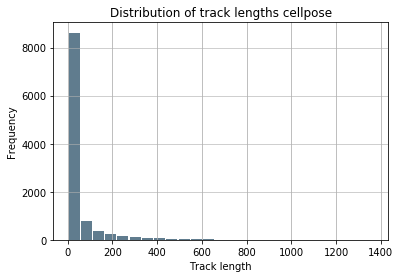

In [8]:
#size, scale = 1000, 10
track_lengths = [len(track) for track in tracks] 
tracks_df = pd.Series(track_lengths)
print(max(tracks_df))

tracks_df.plot.hist(grid=True, bins=25, rwidth=0.9,
                   color='#607c8e')
title = 'Distribution of track lengths cellpose'
plt.title(title)
plt.xlabel('Track length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

### Filter track lengths if desired

In [9]:
filtered_tracks = [track for track in tracks if len(track) > 100] #excludes track lengths below x frames
track_lengths = [len(track) for track in filtered_tracks] 
track_IDs = [track.ID for track in filtered_tracks] 
#track_IDs = natsorted(track_IDs)
print("number of tracks that are in this criterion are = ", len(track_IDs))
print(natsorted(track_IDs))
for i in range(len(track_lengths)):
    print("ID = ", track_IDs[i], "/ Length = ", track_lengths[i])

number of tracks that are in this criterion are =  1274
[1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 15, 17, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 38, 39, 42, 44, 46, 47, 50, 52, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 80, 81, 83, 84, 85, 88, 90, 92, 93, 95, 97, 98, 101, 102, 103, 104, 108, 109, 113, 114, 115, 118, 119, 123, 124, 126, 138, 147, 151, 163, 171, 211, 246, 259, 265, 268, 290, 294, 298, 310, 323, 333, 336, 341, 343, 346, 349, 364, 365, 376, 383, 385, 388, 393, 396, 400, 415, 417, 425, 434, 454, 457, 472, 473, 476, 481, 487, 490, 501, 509, 528, 532, 539, 560, 600, 603, 605, 608, 609, 617, 619, 736, 750, 762, 806, 819, 888, 890, 995, 1029, 1037, 1056, 1069, 1075, 1078, 1091, 1136, 1151, 1312, 1366, 1383, 1410, 1421, 1484, 1533, 1534, 1574, 1582, 1601, 1605, 1629, 1638, 1670, 1675, 1753, 1764, 1766, 1768, 1779, 1780, 1798, 1819, 1826, 1832, 1836, 1841, 1845, 1850, 1865, 1879, 1882, 1897, 1924, 1931, 1934, 1940, 1947, 1987, 2064, 2

# The _NUMBER CRUNCH_ zone

#### Data output directory creation 

In [10]:
mask_type = "cellpose_nuclear_3" # important to specify the origin of the masks so that results are printed correctly

In [11]:
### DIRECTORY CREATION ###
stats_dir = os.path.join(root_path, 'stats') 
mask_type_stats_dir = os.path.join(stats_dir, mask_type)     
    
Path(stats_dir).mkdir(parents=True, exist_ok=True)
Path(mask_type_stats_dir).mkdir(parents=True, exist_ok=True)   

## Calculations - this version measures summed fluoresence intensity over whole mask area

In [23]:
print('Total calculation progress bar below (n/N cells):')
for j, cell in enumerate(tqdm(filtered_tracks)):
    ID = str(filtered_tracks[j].ID)
    #ID = str(1100) #### if only 1 cell required
    print('cell ID = ',ID, 'progress bar below: (n/N frames):')## add to df
    frames = filtered_tracks[j].t
    x = filtered_tracks[j].x 
    y = filtered_tracks[j].y

    fn = "cell_ID_" + ID + ".csv"
    stat_file = os.path.normpath(os.path.join(mask_type_stats_dir, fn))

    df = pd.DataFrame([], columns=['Cell ID', 'Frame', 'GFP Intensity', 'RFP Intensity', 'Phase Intensity', 'Area', 'x','y', 'mask_fn']) #is this assignment of df correct? or does it overwrite "count_cells" above

    new_mask_list = [] #this creates a new mask list of only the necessary frames
    new_gfp_list = []
    new_rfp_list = []
    new_phase_list = []
    for k in frames:
        new_mask_list.append(mask_list[k]) 
        new_gfp_list.append(gfp_list[k])
        new_rfp_list.append(rfp_list[k])
        new_phase_list.append(phase_list[k])

    # below opens a mask image, uses xy coords to select specific mask, then uses that specific mask to measure other images
    for i, mask_name in enumerate(tqdm(new_mask_list)):
        #print(i, frames[i], mask_name, new_gfp_list[i], new_rfp_list[i], new_phase_list[i]) #sanity check to ensure correct images are being loaded+measured

        mask = io.imread(os.path.normpath(os.path.join(mask_dir, mask_name))) #load mask
        xi = int(x[i])
        yi = int(y[i]) #x and y coords
        labelled, n_labels = ndimage.label(mask) 
        
        #this block returns 0-value measurements if the cell_mask is unavailable at this frame, due to tracker-interpolation
        if (labelled[xi,yi] == 0):
            cell_mask = None
            area = None
            gfp_pix_value = None
            rfp_pix_value = None
            phase_pix_value = None
            
        else:
            cell_mask = labelled == labelled[xi,yi] #creating a new mask only including cell of interest
            area = ndimage.sum(cell_mask)

            #load images and measure
            gfp = io.imread(os.path.join(gfp_dir,new_gfp_list[i])) #load gfp image
            gfp_pix_value = ndimage.sum(gfp, cell_mask, 1) #measure cell_mask area of gfp image

            rfp = io.imread(os.path.join(rfp_dir,new_rfp_list[i]))
            rfp_pix_value = ndimage.sum(rfp, cell_mask, 1)

            phase = io.imread(os.path.join(phase_dir,new_phase_list[i]))
            phase_pix_value = ndimage.sum(phase, cell_mask, 1)

        #store measurements in pandas df
        df.loc[i, 'Cell ID'] = ID
        df.loc[i, 'Frame'] = frames[i]
        df.loc[i,'GFP Intensity'] = gfp_pix_value 
        df.loc[i,'RFP Intensity'] = rfp_pix_value
        df.loc[i,'Phase Intensity'] = phase_pix_value 
        df.loc[i,'Area'] = area
        df.loc[i, 'mask_fn'] = mask_name
        df.loc[i,'x'] = xi
        df.loc[i,'y'] = yi

    df.to_csv(stat_file, index=False)  
    #print(df)
print("FINISHHHHEEEEDDDDD")
os.system('spd-say "Master Nathan, your program has finished. I love you."')

Total calculation progress bar below (n/N cells):


cell ID =  688 progress bar below: (n/N frames):



cell ID =  1644 progress bar below: (n/N frames):



cell ID =  1646 progress bar below: (n/N frames):




FINISHHHHEEEEDDDDD


0

## Calculations - this version measures average fluoresence intensity over whole mask area¶

In [14]:
print('Total calculation progress bar below (n/N cells):')
for j, cell in enumerate(tqdm(filtered_tracks)):
    ID = str(filtered_tracks[j].ID)
    #ID = str(1100) #### if only 1 cell required
    print('cell ID = ',ID, 'progress bar below: (n/N frames):')## add to df
    frames = filtered_tracks[j].t
    x = filtered_tracks[j].x 
    y = filtered_tracks[j].y

    fn = "cell_ID_" + ID + ".csv"
    stat_file = os.path.normpath(os.path.join(mask_type_stats_dir, fn))

    df = pd.DataFrame([], columns=['Cell ID', 'Frame', 'GFP Intensity', 'RFP Intensity', 'Phase Intensity', 'Area', 'x','y', 'mask_fn']) #is this assignment of df correct? or does it overwrite "count_cells" above

    new_mask_list = [] #this creates a new mask list of only the necessary frames
    new_gfp_list = []
    new_rfp_list = []
    new_phase_list = []
    for k in frames:
        new_mask_list.append(mask_list[k]) 
        new_gfp_list.append(gfp_list[k])
        new_rfp_list.append(rfp_list[k])
        #new_phase_list.append(phase_list[k])

    # below opens a mask image, uses xy coords to select specific mask, then uses that specific mask to measure other images
    for i, mask_name in enumerate(tqdm(new_mask_list)):
        #print(i, frames[i], mask_name, new_gfp_list[i], new_rfp_list[i], new_phase_list[i]) #sanity check to ensure correct images are being loaded+measured

        mask = io.imread(os.path.normpath(os.path.join(mask_dir, mask_name))) #load mask
        xi = int(x[i])
        yi = int(y[i]) #x and y coords
        labelled, n_labels = ndimage.label(mask) 
        
        #this block returns 0-value measurements if the cell_mask is unavailable at this frame, due to tracker-interpolation
        if (labelled[xi,yi] == 0):
            cell_mask = None
            area = None
            gfp_pix_value = None
            rfp_pix_value = None
            #phase_pix_value = None
            
        else:
            cell_mask = labelled == labelled[xi,yi] #creating a new mask only including cell of interest
            area = ndimage.sum(cell_mask)

            #load images and measure
            gfp = io.imread(os.path.join(gfp_dir,new_gfp_list[i])) #load gfp image
            gfp_pix_value = ndimage.sum(gfp, cell_mask, 1) #measure cell_mask area of gfp image
            mean_gfp_value = gfp_pix_value / area
            rfp = io.imread(os.path.join(rfp_dir,new_rfp_list[i]))
            rfp_pix_value = ndimage.sum(rfp, cell_mask, 1)
            mean_rfp_value = rfp_pix_value / area
            #phase = io.imread(os.path.join(phase_dir,new_phase_list[i]))
            #phase_pix_value = ndimage.sum(phase, cell_mask, 1)
            #mean_phase_value = phase_pix_value / area
        #store measurements in pandas df
        df.loc[i, 'Cell ID'] = ID
        df.loc[i, 'Frame'] = frames[i]
        df.loc[i,'GFP Intensity'] = gfp_pix_value 
        df.loc[i, 'Mean GFP Intensity'] = mean_gfp_value
        df.loc[i,'RFP Intensity'] = rfp_pix_value
        df.loc[i, 'Mean RFP Intensity'] = mean_rfp_value
        #df.loc[i,'Phase Intensity'] = phase_pix_value 
        #df.loc[i, 'Mean Phase Intensity'] = mean_phase_value
        df.loc[i,'Area'] = area
        df.loc[i, 'mask_fn'] = mask_name
        df.loc[i,'x'] = xi
        df.loc[i,'y'] = yi

    df.to_csv(stat_file, index=False)  
    #print(df)
print("FINISHHHHEEEEDDDDD")
os.system('spd-say "Master Nathan, your program has finished. I love you."')

Total calculation progress bar below (n/N cells):


cell ID =  75 progress bar below: (n/N frames):



cell ID =  88 progress bar below: (n/N frames):



cell ID =  85 progress bar below: (n/N frames):



cell ID =  84 progress bar below: (n/N frames):



cell ID =  83 progress bar below: (n/N frames):



cell ID =  81 progress bar below: (n/N frames):



cell ID =  80 progress bar below: (n/N frames):



cell ID =  77 progress bar below: (n/N frames):



cell ID =  76 progress bar below: (n/N frames):



cell ID =  90 progress bar below: (n/N frames):



cell ID =  74 progress bar below: (n/N frames):



cell ID =  73 progress bar below: (n/N frames):



cell ID =  72 progress bar below: (n/N frames):



cell ID =  71 progress bar below: (n/N frames):



cell ID =  69 progress bar below: (n/N frames):



cell ID =  68 progress bar below: (n/N frames):



cell ID =  67 progress bar below: (n/N frames):



cell ID =  66 progress bar below: (n/N frames):



cell ID =  64 progress bar below: (n/N frames):



cell ID =  63 progress bar below: (n/N frames):



cell ID =  62 progress bar below: (n/N frames):



cell ID =  61 progress bar below: (n/N frames):



cell ID =  104 progress bar below: (n/N frames):



cell ID =  1 progress bar below: (n/N frames):



cell ID =  115 progress bar below: (n/N frames):



cell ID =  114 progress bar below: (n/N frames):



cell ID =  113 progress bar below: (n/N frames):



cell ID =  109 progress bar below: (n/N frames):



cell ID =  108 progress bar below: (n/N frames):



cell ID =  2 progress bar below: (n/N frames):



cell ID =  103 progress bar below: (n/N frames):



cell ID =  102 progress bar below: (n/N frames):



cell ID =  101 progress bar below: (n/N frames):



cell ID =  98 progress bar below: (n/N frames):



cell ID =  97 progress bar below: (n/N frames):



cell ID =  95 progress bar below: (n/N frames):



cell ID =  93 progress bar below: (n/N frames):



cell ID =  92 progress bar below: (n/N frames):



cell ID =  30 progress bar below: (n/N frames):



cell ID =  29 progress bar below: (n/N frames):



cell ID =  28 progress bar below: (n/N frames):



cell ID =  27 progress bar below: (n/N frames):



cell ID =  26 progress bar below: (n/N frames):



cell ID =  25 progress bar below: (n/N frames):



cell ID =  24 progress bar below: (n/N frames):



cell ID =  23 progress bar below: (n/N frames):



cell ID =  20 progress bar below: (n/N frames):



cell ID =  19 progress bar below: (n/N frames):



cell ID =  17 progress bar below: (n/N frames):



cell ID =  15 progress bar below: (n/N frames):



cell ID =  14 progress bar below: (n/N frames):



cell ID =  13 progress bar below: (n/N frames):



cell ID =  12 progress bar below: (n/N frames):



cell ID =  11 progress bar below: (n/N frames):



cell ID =  8 progress bar below: (n/N frames):



cell ID =  6 progress bar below: (n/N frames):



cell ID =  5 progress bar below: (n/N frames):



cell ID =  4 progress bar below: (n/N frames):



cell ID =  3 progress bar below: (n/N frames):



cell ID =  60 progress bar below: (n/N frames):



cell ID =  32 progress bar below: (n/N frames):



cell ID =  58 progress bar below: (n/N frames):



cell ID =  57 progress bar below: (n/N frames):



cell ID =  56 progress bar below: (n/N frames):



cell ID =  55 progress bar below: (n/N frames):



cell ID =  54 progress bar below: (n/N frames):



cell ID =  52 progress bar below: (n/N frames):



cell ID =  50 progress bar below: (n/N frames):



cell ID =  47 progress bar below: (n/N frames):



cell ID =  46 progress bar below: (n/N frames):



cell ID =  44 progress bar below: (n/N frames):



cell ID =  31 progress bar below: (n/N frames):



cell ID =  38 progress bar below: (n/N frames):



cell ID =  39 progress bar below: (n/N frames):



cell ID =  42 progress bar below: (n/N frames):



cell ID =  124 progress bar below: (n/N frames):



cell ID =  123 progress bar below: (n/N frames):



cell ID =  118 progress bar below: (n/N frames):



cell ID =  119 progress bar below: (n/N frames):



cell ID =  126 progress bar below: (n/N frames):



cell ID =  138 progress bar below: (n/N frames):



cell ID =  147 progress bar below: (n/N frames):



cell ID =  151 progress bar below: (n/N frames):



cell ID =  163 progress bar below: (n/N frames):



cell ID =  171 progress bar below: (n/N frames):



cell ID =  211 progress bar below: (n/N frames):



cell ID =  246 progress bar below: (n/N frames):



cell ID =  259 progress bar below: (n/N frames):



cell ID =  265 progress bar below: (n/N frames):



cell ID =  268 progress bar below: (n/N frames):



cell ID =  290 progress bar below: (n/N frames):



cell ID =  294 progress bar below: (n/N frames):



cell ID =  298 progress bar below: (n/N frames):



cell ID =  310 progress bar below: (n/N frames):



cell ID =  323 progress bar below: (n/N frames):



cell ID =  333 progress bar below: (n/N frames):



cell ID =  336 progress bar below: (n/N frames):



cell ID =  341 progress bar below: (n/N frames):



cell ID =  343 progress bar below: (n/N frames):



cell ID =  346 progress bar below: (n/N frames):



cell ID =  349 progress bar below: (n/N frames):



cell ID =  364 progress bar below: (n/N frames):



cell ID =  365 progress bar below: (n/N frames):



cell ID =  376 progress bar below: (n/N frames):



cell ID =  383 progress bar below: (n/N frames):



cell ID =  385 progress bar below: (n/N frames):



cell ID =  388 progress bar below: (n/N frames):



cell ID =  393 progress bar below: (n/N frames):



cell ID =  396 progress bar below: (n/N frames):



cell ID =  400 progress bar below: (n/N frames):



cell ID =  415 progress bar below: (n/N frames):



cell ID =  417 progress bar below: (n/N frames):



cell ID =  425 progress bar below: (n/N frames):



cell ID =  434 progress bar below: (n/N frames):



cell ID =  454 progress bar below: (n/N frames):



cell ID =  457 progress bar below: (n/N frames):



cell ID =  472 progress bar below: (n/N frames):



cell ID =  473 progress bar below: (n/N frames):



cell ID =  476 progress bar below: (n/N frames):



cell ID =  481 progress bar below: (n/N frames):



cell ID =  487 progress bar below: (n/N frames):



cell ID =  490 progress bar below: (n/N frames):



cell ID =  501 progress bar below: (n/N frames):



cell ID =  509 progress bar below: (n/N frames):



cell ID =  528 progress bar below: (n/N frames):



cell ID =  532 progress bar below: (n/N frames):



cell ID =  539 progress bar below: (n/N frames):



cell ID =  560 progress bar below: (n/N frames):



cell ID =  600 progress bar below: (n/N frames):



cell ID =  603 progress bar below: (n/N frames):



cell ID =  605 progress bar below: (n/N frames):



cell ID =  608 progress bar below: (n/N frames):



cell ID =  609 progress bar below: (n/N frames):



cell ID =  617 progress bar below: (n/N frames):



cell ID =  619 progress bar below: (n/N frames):



cell ID =  736 progress bar below: (n/N frames):



cell ID =  750 progress bar below: (n/N frames):



cell ID =  762 progress bar below: (n/N frames):



cell ID =  806 progress bar below: (n/N frames):



cell ID =  819 progress bar below: (n/N frames):



cell ID =  888 progress bar below: (n/N frames):



cell ID =  890 progress bar below: (n/N frames):



cell ID =  995 progress bar below: (n/N frames):



cell ID =  1029 progress bar below: (n/N frames):



cell ID =  1037 progress bar below: (n/N frames):



cell ID =  1056 progress bar below: (n/N frames):



cell ID =  1075 progress bar below: (n/N frames):



cell ID =  1069 progress bar below: (n/N frames):



cell ID =  1078 progress bar below: (n/N frames):



cell ID =  1091 progress bar below: (n/N frames):



cell ID =  1136 progress bar below: (n/N frames):



cell ID =  1151 progress bar below: (n/N frames):



cell ID =  1312 progress bar below: (n/N frames):



cell ID =  1366 progress bar below: (n/N frames):



cell ID =  1383 progress bar below: (n/N frames):



cell ID =  1410 progress bar below: (n/N frames):



cell ID =  1421 progress bar below: (n/N frames):



cell ID =  1484 progress bar below: (n/N frames):



cell ID =  1534 progress bar below: (n/N frames):



cell ID =  1533 progress bar below: (n/N frames):



cell ID =  1574 progress bar below: (n/N frames):



cell ID =  1582 progress bar below: (n/N frames):



cell ID =  1601 progress bar below: (n/N frames):



cell ID =  1605 progress bar below: (n/N frames):



cell ID =  1629 progress bar below: (n/N frames):



cell ID =  1638 progress bar below: (n/N frames):



cell ID =  1670 progress bar below: (n/N frames):



cell ID =  1675 progress bar below: (n/N frames):



cell ID =  1753 progress bar below: (n/N frames):



cell ID =  1768 progress bar below: (n/N frames):



cell ID =  1766 progress bar below: (n/N frames):



cell ID =  1764 progress bar below: (n/N frames):



cell ID =  1780 progress bar below: (n/N frames):



cell ID =  1779 progress bar below: (n/N frames):



cell ID =  1798 progress bar below: (n/N frames):



cell ID =  1819 progress bar below: (n/N frames):



cell ID =  1826 progress bar below: (n/N frames):



cell ID =  1832 progress bar below: (n/N frames):



cell ID =  1836 progress bar below: (n/N frames):



cell ID =  1841 progress bar below: (n/N frames):



cell ID =  1845 progress bar below: (n/N frames):



cell ID =  1850 progress bar below: (n/N frames):



cell ID =  1865 progress bar below: (n/N frames):



cell ID =  1882 progress bar below: (n/N frames):



cell ID =  1879 progress bar below: (n/N frames):



cell ID =  1897 progress bar below: (n/N frames):



cell ID =  1924 progress bar below: (n/N frames):



cell ID =  1934 progress bar below: (n/N frames):



cell ID =  1931 progress bar below: (n/N frames):



cell ID =  1940 progress bar below: (n/N frames):



cell ID =  1947 progress bar below: (n/N frames):



cell ID =  1987 progress bar below: (n/N frames):



cell ID =  2064 progress bar below: (n/N frames):



cell ID =  2072 progress bar below: (n/N frames):



cell ID =  2093 progress bar below: (n/N frames):



cell ID =  2099 progress bar below: (n/N frames):



cell ID =  2105 progress bar below: (n/N frames):



cell ID =  2130 progress bar below: (n/N frames):



cell ID =  2150 progress bar below: (n/N frames):



cell ID =  2158 progress bar below: (n/N frames):



cell ID =  2137 progress bar below: (n/N frames):



cell ID =  2138 progress bar below: (n/N frames):



cell ID =  2144 progress bar below: (n/N frames):



cell ID =  2164 progress bar below: (n/N frames):



cell ID =  2184 progress bar below: (n/N frames):



cell ID =  2182 progress bar below: (n/N frames):



cell ID =  2180 progress bar below: (n/N frames):



cell ID =  2172 progress bar below: (n/N frames):



cell ID =  2200 progress bar below: (n/N frames):



cell ID =  2228 progress bar below: (n/N frames):



cell ID =  2221 progress bar below: (n/N frames):



cell ID =  2219 progress bar below: (n/N frames):



cell ID =  2218 progress bar below: (n/N frames):



cell ID =  2237 progress bar below: (n/N frames):



cell ID =  2238 progress bar below: (n/N frames):



cell ID =  2244 progress bar below: (n/N frames):



cell ID =  2256 progress bar below: (n/N frames):



cell ID =  2266 progress bar below: (n/N frames):



cell ID =  2276 progress bar below: (n/N frames):



cell ID =  2318 progress bar below: (n/N frames):



cell ID =  2338 progress bar below: (n/N frames):



cell ID =  2359 progress bar below: (n/N frames):



cell ID =  2361 progress bar below: (n/N frames):



cell ID =  2362 progress bar below: (n/N frames):



cell ID =  2364 progress bar below: (n/N frames):



cell ID =  2365 progress bar below: (n/N frames):



cell ID =  2368 progress bar below: (n/N frames):



cell ID =  2369 progress bar below: (n/N frames):



cell ID =  2371 progress bar below: (n/N frames):



cell ID =  2346 progress bar below: (n/N frames):



cell ID =  2348 progress bar below: (n/N frames):



cell ID =  2352 progress bar below: (n/N frames):



cell ID =  2353 progress bar below: (n/N frames):



cell ID =  2383 progress bar below: (n/N frames):



cell ID =  2372 progress bar below: (n/N frames):



cell ID =  2398 progress bar below: (n/N frames):



cell ID =  2394 progress bar below: (n/N frames):



cell ID =  2438 progress bar below: (n/N frames):



cell ID =  2442 progress bar below: (n/N frames):



cell ID =  2441 progress bar below: (n/N frames):



cell ID =  2455 progress bar below: (n/N frames):



cell ID =  2478 progress bar below: (n/N frames):



cell ID =  2491 progress bar below: (n/N frames):



cell ID =  2490 progress bar below: (n/N frames):



cell ID =  2488 progress bar below: (n/N frames):



cell ID =  2498 progress bar below: (n/N frames):



cell ID =  2515 progress bar below: (n/N frames):



cell ID =  2520 progress bar below: (n/N frames):



cell ID =  2533 progress bar below: (n/N frames):



cell ID =  2552 progress bar below: (n/N frames):



cell ID =  2557 progress bar below: (n/N frames):



cell ID =  2558 progress bar below: (n/N frames):



cell ID =  2566 progress bar below: (n/N frames):



cell ID =  2568 progress bar below: (n/N frames):



cell ID =  2572 progress bar below: (n/N frames):



cell ID =  2636 progress bar below: (n/N frames):



cell ID =  2656 progress bar below: (n/N frames):



cell ID =  2648 progress bar below: (n/N frames):



cell ID =  2676 progress bar below: (n/N frames):



cell ID =  2763 progress bar below: (n/N frames):



cell ID =  2775 progress bar below: (n/N frames):



cell ID =  2819 progress bar below: (n/N frames):



cell ID =  2830 progress bar below: (n/N frames):



cell ID =  2860 progress bar below: (n/N frames):



cell ID =  2866 progress bar below: (n/N frames):



cell ID =  2882 progress bar below: (n/N frames):



cell ID =  2918 progress bar below: (n/N frames):



cell ID =  2916 progress bar below: (n/N frames):



cell ID =  2922 progress bar below: (n/N frames):



cell ID =  2924 progress bar below: (n/N frames):



cell ID =  2928 progress bar below: (n/N frames):



cell ID =  2950 progress bar below: (n/N frames):



cell ID =  2963 progress bar below: (n/N frames):



cell ID =  2982 progress bar below: (n/N frames):



cell ID =  2992 progress bar below: (n/N frames):



cell ID =  3018 progress bar below: (n/N frames):



cell ID =  3022 progress bar below: (n/N frames):



cell ID =  3030 progress bar below: (n/N frames):



cell ID =  3053 progress bar below: (n/N frames):



cell ID =  3040 progress bar below: (n/N frames):



cell ID =  3072 progress bar below: (n/N frames):



cell ID =  3071 progress bar below: (n/N frames):



cell ID =  3069 progress bar below: (n/N frames):



cell ID =  3119 progress bar below: (n/N frames):



cell ID =  3118 progress bar below: (n/N frames):



cell ID =  3114 progress bar below: (n/N frames):



cell ID =  3113 progress bar below: (n/N frames):



cell ID =  3129 progress bar below: (n/N frames):



cell ID =  3137 progress bar below: (n/N frames):



cell ID =  3149 progress bar below: (n/N frames):



cell ID =  3155 progress bar below: (n/N frames):



cell ID =  3156 progress bar below: (n/N frames):



cell ID =  3167 progress bar below: (n/N frames):



cell ID =  3159 progress bar below: (n/N frames):



cell ID =  3189 progress bar below: (n/N frames):



cell ID =  3213 progress bar below: (n/N frames):



cell ID =  3260 progress bar below: (n/N frames):



cell ID =  3258 progress bar below: (n/N frames):



cell ID =  3293 progress bar below: (n/N frames):



cell ID =  3290 progress bar below: (n/N frames):



cell ID =  3296 progress bar below: (n/N frames):



cell ID =  3305 progress bar below: (n/N frames):



cell ID =  3317 progress bar below: (n/N frames):



cell ID =  3361 progress bar below: (n/N frames):



cell ID =  3369 progress bar below: (n/N frames):



cell ID =  3375 progress bar below: (n/N frames):



cell ID =  3352 progress bar below: (n/N frames):



cell ID =  3339 progress bar below: (n/N frames):



cell ID =  3348 progress bar below: (n/N frames):



cell ID =  3350 progress bar below: (n/N frames):



cell ID =  3379 progress bar below: (n/N frames):



cell ID =  3382 progress bar below: (n/N frames):



cell ID =  3394 progress bar below: (n/N frames):



cell ID =  3397 progress bar below: (n/N frames):



cell ID =  3401 progress bar below: (n/N frames):



cell ID =  3405 progress bar below: (n/N frames):



cell ID =  3442 progress bar below: (n/N frames):



cell ID =  3443 progress bar below: (n/N frames):



cell ID =  3528 progress bar below: (n/N frames):



cell ID =  3487 progress bar below: (n/N frames):



cell ID =  3577 progress bar below: (n/N frames):



cell ID =  3591 progress bar below: (n/N frames):



cell ID =  3592 progress bar below: (n/N frames):



cell ID =  3606 progress bar below: (n/N frames):



cell ID =  3628 progress bar below: (n/N frames):



cell ID =  3624 progress bar below: (n/N frames):



cell ID =  3637 progress bar below: (n/N frames):



cell ID =  3645 progress bar below: (n/N frames):



cell ID =  3678 progress bar below: (n/N frames):



cell ID =  3679 progress bar below: (n/N frames):



cell ID =  3681 progress bar below: (n/N frames):



cell ID =  3684 progress bar below: (n/N frames):



cell ID =  3669 progress bar below: (n/N frames):



cell ID =  3651 progress bar below: (n/N frames):



cell ID =  3655 progress bar below: (n/N frames):



cell ID =  3670 progress bar below: (n/N frames):



cell ID =  3668 progress bar below: (n/N frames):



cell ID =  3667 progress bar below: (n/N frames):



cell ID =  3665 progress bar below: (n/N frames):



cell ID =  3707 progress bar below: (n/N frames):



cell ID =  3705 progress bar below: (n/N frames):



cell ID =  3702 progress bar below: (n/N frames):



cell ID =  3701 progress bar below: (n/N frames):



cell ID =  3699 progress bar below: (n/N frames):



cell ID =  3718 progress bar below: (n/N frames):



cell ID =  3876 progress bar below: (n/N frames):



cell ID =  3884 progress bar below: (n/N frames):



cell ID =  3886 progress bar below: (n/N frames):



cell ID =  3885 progress bar below: (n/N frames):



cell ID =  3924 progress bar below: (n/N frames):



cell ID =  3937 progress bar below: (n/N frames):



cell ID =  3926 progress bar below: (n/N frames):



cell ID =  3944 progress bar below: (n/N frames):



cell ID =  3940 progress bar below: (n/N frames):



cell ID =  3960 progress bar below: (n/N frames):



cell ID =  3972 progress bar below: (n/N frames):



cell ID =  3976 progress bar below: (n/N frames):



cell ID =  3983 progress bar below: (n/N frames):



cell ID =  4002 progress bar below: (n/N frames):



cell ID =  4016 progress bar below: (n/N frames):



cell ID =  4030 progress bar below: (n/N frames):



cell ID =  4025 progress bar below: (n/N frames):



cell ID =  4048 progress bar below: (n/N frames):



cell ID =  4057 progress bar below: (n/N frames):



cell ID =  4060 progress bar below: (n/N frames):



cell ID =  4059 progress bar below: (n/N frames):



cell ID =  4084 progress bar below: (n/N frames):



cell ID =  4072 progress bar below: (n/N frames):



cell ID =  4071 progress bar below: (n/N frames):



cell ID =  4104 progress bar below: (n/N frames):



cell ID =  4091 progress bar below: (n/N frames):



cell ID =  4180 progress bar below: (n/N frames):



cell ID =  4291 progress bar below: (n/N frames):



cell ID =  4296 progress bar below: (n/N frames):



cell ID =  4298 progress bar below: (n/N frames):



cell ID =  4317 progress bar below: (n/N frames):



cell ID =  4312 progress bar below: (n/N frames):



cell ID =  4307 progress bar below: (n/N frames):



cell ID =  4346 progress bar below: (n/N frames):



cell ID =  4331 progress bar below: (n/N frames):



cell ID =  4324 progress bar below: (n/N frames):



cell ID =  4336 progress bar below: (n/N frames):



cell ID =  4355 progress bar below: (n/N frames):



cell ID =  4357 progress bar below: (n/N frames):



cell ID =  4367 progress bar below: (n/N frames):



cell ID =  4391 progress bar below: (n/N frames):



cell ID =  4394 progress bar below: (n/N frames):



cell ID =  4415 progress bar below: (n/N frames):



cell ID =  4422 progress bar below: (n/N frames):



cell ID =  4423 progress bar below: (n/N frames):



cell ID =  4428 progress bar below: (n/N frames):



cell ID =  4399 progress bar below: (n/N frames):



cell ID =  4402 progress bar below: (n/N frames):



cell ID =  4409 progress bar below: (n/N frames):



cell ID =  4430 progress bar below: (n/N frames):



cell ID =  4437 progress bar below: (n/N frames):



cell ID =  4434 progress bar below: (n/N frames):



cell ID =  4433 progress bar below: (n/N frames):



cell ID =  4451 progress bar below: (n/N frames):



cell ID =  4458 progress bar below: (n/N frames):



cell ID =  4467 progress bar below: (n/N frames):



cell ID =  4488 progress bar below: (n/N frames):



cell ID =  4482 progress bar below: (n/N frames):



cell ID =  4483 progress bar below: (n/N frames):



cell ID =  4525 progress bar below: (n/N frames):



cell ID =  4499 progress bar below: (n/N frames):



cell ID =  4505 progress bar below: (n/N frames):



cell ID =  4504 progress bar below: (n/N frames):



cell ID =  4534 progress bar below: (n/N frames):



cell ID =  4553 progress bar below: (n/N frames):



cell ID =  4552 progress bar below: (n/N frames):



cell ID =  4575 progress bar below: (n/N frames):



cell ID =  4573 progress bar below: (n/N frames):



cell ID =  4559 progress bar below: (n/N frames):



cell ID =  4570 progress bar below: (n/N frames):



cell ID =  4566 progress bar below: (n/N frames):



cell ID =  4700 progress bar below: (n/N frames):



cell ID =  4698 progress bar below: (n/N frames):



cell ID =  4708 progress bar below: (n/N frames):



cell ID =  4712 progress bar below: (n/N frames):



cell ID =  4686 progress bar below: (n/N frames):



cell ID =  4752 progress bar below: (n/N frames):



cell ID =  4713 progress bar below: (n/N frames):



cell ID =  4727 progress bar below: (n/N frames):



cell ID =  4617 progress bar below: (n/N frames):



cell ID =  4593 progress bar below: (n/N frames):



cell ID =  4658 progress bar below: (n/N frames):



cell ID =  4664 progress bar below: (n/N frames):



cell ID =  4627 progress bar below: (n/N frames):



cell ID =  4758 progress bar below: (n/N frames):



cell ID =  4809 progress bar below: (n/N frames):



cell ID =  4806 progress bar below: (n/N frames):



cell ID =  4821 progress bar below: (n/N frames):



cell ID =  4825 progress bar below: (n/N frames):



cell ID =  4773 progress bar below: (n/N frames):



cell ID =  4797 progress bar below: (n/N frames):



cell ID =  4834 progress bar below: (n/N frames):



cell ID =  4840 progress bar below: (n/N frames):



cell ID =  4862 progress bar below: (n/N frames):



cell ID =  4857 progress bar below: (n/N frames):



cell ID =  4852 progress bar below: (n/N frames):



cell ID =  4844 progress bar below: (n/N frames):



cell ID =  4884 progress bar below: (n/N frames):



cell ID =  4882 progress bar below: (n/N frames):



cell ID =  4881 progress bar below: (n/N frames):



cell ID =  4878 progress bar below: (n/N frames):



cell ID =  4874 progress bar below: (n/N frames):



cell ID =  4871 progress bar below: (n/N frames):



cell ID =  4890 progress bar below: (n/N frames):



cell ID =  4894 progress bar below: (n/N frames):



cell ID =  4941 progress bar below: (n/N frames):



cell ID =  4939 progress bar below: (n/N frames):



cell ID =  4937 progress bar below: (n/N frames):



cell ID =  4949 progress bar below: (n/N frames):



cell ID =  4950 progress bar below: (n/N frames):



cell ID =  4953 progress bar below: (n/N frames):



cell ID =  4959 progress bar below: (n/N frames):



cell ID =  4909 progress bar below: (n/N frames):



cell ID =  4906 progress bar below: (n/N frames):



cell ID =  4905 progress bar below: (n/N frames):



cell ID =  4904 progress bar below: (n/N frames):



cell ID =  4902 progress bar below: (n/N frames):



cell ID =  4925 progress bar below: (n/N frames):



cell ID =  4900 progress bar below: (n/N frames):



cell ID =  4898 progress bar below: (n/N frames):



cell ID =  4897 progress bar below: (n/N frames):



cell ID =  4896 progress bar below: (n/N frames):



cell ID =  4895 progress bar below: (n/N frames):



cell ID =  4926 progress bar below: (n/N frames):



cell ID =  4911 progress bar below: (n/N frames):



cell ID =  4910 progress bar below: (n/N frames):



cell ID =  4923 progress bar below: (n/N frames):



cell ID =  4921 progress bar below: (n/N frames):



cell ID =  4919 progress bar below: (n/N frames):



cell ID =  4918 progress bar below: (n/N frames):



cell ID =  4917 progress bar below: (n/N frames):



cell ID =  4916 progress bar below: (n/N frames):



cell ID =  4914 progress bar below: (n/N frames):



cell ID =  4913 progress bar below: (n/N frames):



cell ID =  5025 progress bar below: (n/N frames):



cell ID =  5036 progress bar below: (n/N frames):



cell ID =  5033 progress bar below: (n/N frames):



cell ID =  5082 progress bar below: (n/N frames):



cell ID =  5061 progress bar below: (n/N frames):



cell ID =  5059 progress bar below: (n/N frames):



cell ID =  4988 progress bar below: (n/N frames):



cell ID =  4986 progress bar below: (n/N frames):



cell ID =  4969 progress bar below: (n/N frames):



cell ID =  5024 progress bar below: (n/N frames):



cell ID =  5021 progress bar below: (n/N frames):



cell ID =  5019 progress bar below: (n/N frames):



cell ID =  4994 progress bar below: (n/N frames):



cell ID =  5128 progress bar below: (n/N frames):



cell ID =  5090 progress bar below: (n/N frames):



cell ID =  5173 progress bar below: (n/N frames):



cell ID =  5165 progress bar below: (n/N frames):



cell ID =  5161 progress bar below: (n/N frames):



cell ID =  5152 progress bar below: (n/N frames):



cell ID =  5146 progress bar below: (n/N frames):



cell ID =  5177 progress bar below: (n/N frames):



cell ID =  5190 progress bar below: (n/N frames):



cell ID =  5192 progress bar below: (n/N frames):



cell ID =  5211 progress bar below: (n/N frames):



cell ID =  5223 progress bar below: (n/N frames):



cell ID =  5222 progress bar below: (n/N frames):



cell ID =  5221 progress bar below: (n/N frames):



cell ID =  5220 progress bar below: (n/N frames):



cell ID =  5215 progress bar below: (n/N frames):



cell ID =  5236 progress bar below: (n/N frames):



cell ID =  5238 progress bar below: (n/N frames):



cell ID =  5239 progress bar below: (n/N frames):



cell ID =  5240 progress bar below: (n/N frames):



cell ID =  5251 progress bar below: (n/N frames):



cell ID =  5245 progress bar below: (n/N frames):



cell ID =  5248 progress bar below: (n/N frames):



cell ID =  5246 progress bar below: (n/N frames):



cell ID =  5261 progress bar below: (n/N frames):



cell ID =  5257 progress bar below: (n/N frames):



cell ID =  5271 progress bar below: (n/N frames):



cell ID =  5270 progress bar below: (n/N frames):



cell ID =  5268 progress bar below: (n/N frames):



cell ID =  5264 progress bar below: (n/N frames):



cell ID =  5279 progress bar below: (n/N frames):



cell ID =  5278 progress bar below: (n/N frames):



cell ID =  5356 progress bar below: (n/N frames):



cell ID =  5360 progress bar below: (n/N frames):



cell ID =  5306 progress bar below: (n/N frames):



cell ID =  5315 progress bar below: (n/N frames):



cell ID =  5392 progress bar below: (n/N frames):



cell ID =  5403 progress bar below: (n/N frames):



cell ID =  5405 progress bar below: (n/N frames):



cell ID =  5418 progress bar below: (n/N frames):



cell ID =  5415 progress bar below: (n/N frames):



cell ID =  5412 progress bar below: (n/N frames):



cell ID =  5410 progress bar below: (n/N frames):



cell ID =  5409 progress bar below: (n/N frames):



cell ID =  5408 progress bar below: (n/N frames):



cell ID =  5428 progress bar below: (n/N frames):



cell ID =  5427 progress bar below: (n/N frames):



cell ID =  5435 progress bar below: (n/N frames):



cell ID =  5448 progress bar below: (n/N frames):



cell ID =  5442 progress bar below: (n/N frames):



cell ID =  5438 progress bar below: (n/N frames):



cell ID =  5436 progress bar below: (n/N frames):



cell ID =  5453 progress bar below: (n/N frames):



cell ID =  5455 progress bar below: (n/N frames):



cell ID =  5456 progress bar below: (n/N frames):



cell ID =  5457 progress bar below: (n/N frames):



cell ID =  5463 progress bar below: (n/N frames):



cell ID =  5464 progress bar below: (n/N frames):



cell ID =  5556 progress bar below: (n/N frames):



cell ID =  5566 progress bar below: (n/N frames):



cell ID =  5560 progress bar below: (n/N frames):



cell ID =  5574 progress bar below: (n/N frames):



cell ID =  5575 progress bar below: (n/N frames):



cell ID =  5576 progress bar below: (n/N frames):



cell ID =  5585 progress bar below: (n/N frames):



cell ID =  5593 progress bar below: (n/N frames):



cell ID =  5600 progress bar below: (n/N frames):



cell ID =  5601 progress bar below: (n/N frames):



cell ID =  5623 progress bar below: (n/N frames):



cell ID =  5617 progress bar below: (n/N frames):



cell ID =  5626 progress bar below: (n/N frames):



cell ID =  5636 progress bar below: (n/N frames):



cell ID =  5645 progress bar below: (n/N frames):



cell ID =  5654 progress bar below: (n/N frames):



cell ID =  5663 progress bar below: (n/N frames):



cell ID =  5677 progress bar below: (n/N frames):



cell ID =  5679 progress bar below: (n/N frames):



cell ID =  5675 progress bar below: (n/N frames):



cell ID =  5672 progress bar below: (n/N frames):



cell ID =  5682 progress bar below: (n/N frames):



cell ID =  5689 progress bar below: (n/N frames):



cell ID =  5687 progress bar below: (n/N frames):



cell ID =  5686 progress bar below: (n/N frames):



cell ID =  5697 progress bar below: (n/N frames):



cell ID =  5771 progress bar below: (n/N frames):



cell ID =  5718 progress bar below: (n/N frames):



cell ID =  5721 progress bar below: (n/N frames):



cell ID =  5794 progress bar below: (n/N frames):



cell ID =  5795 progress bar below: (n/N frames):



cell ID =  5793 progress bar below: (n/N frames):



cell ID =  5789 progress bar below: (n/N frames):



cell ID =  5797 progress bar below: (n/N frames):



cell ID =  5798 progress bar below: (n/N frames):



cell ID =  5811 progress bar below: (n/N frames):



cell ID =  5808 progress bar below: (n/N frames):



cell ID =  5804 progress bar below: (n/N frames):



cell ID =  5803 progress bar below: (n/N frames):



cell ID =  5816 progress bar below: (n/N frames):



cell ID =  5820 progress bar below: (n/N frames):



cell ID =  5887 progress bar below: (n/N frames):



cell ID =  5900 progress bar below: (n/N frames):



cell ID =  5895 progress bar below: (n/N frames):



cell ID =  5904 progress bar below: (n/N frames):



cell ID =  5906 progress bar below: (n/N frames):



cell ID =  5917 progress bar below: (n/N frames):



cell ID =  5912 progress bar below: (n/N frames):



cell ID =  5979 progress bar below: (n/N frames):



cell ID =  5969 progress bar below: (n/N frames):



cell ID =  5985 progress bar below: (n/N frames):



cell ID =  5930 progress bar below: (n/N frames):



cell ID =  5928 progress bar below: (n/N frames):



cell ID =  6006 progress bar below: (n/N frames):



cell ID =  6007 progress bar below: (n/N frames):



cell ID =  6020 progress bar below: (n/N frames):



cell ID =  6025 progress bar below: (n/N frames):



cell ID =  6032 progress bar below: (n/N frames):



cell ID =  6031 progress bar below: (n/N frames):



cell ID =  6030 progress bar below: (n/N frames):



cell ID =  6027 progress bar below: (n/N frames):



cell ID =  6041 progress bar below: (n/N frames):



cell ID =  6039 progress bar below: (n/N frames):



cell ID =  6052 progress bar below: (n/N frames):



cell ID =  6051 progress bar below: (n/N frames):



cell ID =  6049 progress bar below: (n/N frames):



cell ID =  6046 progress bar below: (n/N frames):



cell ID =  6058 progress bar below: (n/N frames):



cell ID =  6060 progress bar below: (n/N frames):



cell ID =  6061 progress bar below: (n/N frames):



cell ID =  6068 progress bar below: (n/N frames):



cell ID =  6078 progress bar below: (n/N frames):



cell ID =  6096 progress bar below: (n/N frames):



cell ID =  6099 progress bar below: (n/N frames):



cell ID =  6119 progress bar below: (n/N frames):



cell ID =  6103 progress bar below: (n/N frames):



cell ID =  6142 progress bar below: (n/N frames):



cell ID =  6202 progress bar below: (n/N frames):



cell ID =  6205 progress bar below: (n/N frames):



cell ID =  6208 progress bar below: (n/N frames):



cell ID =  6211 progress bar below: (n/N frames):



cell ID =  6222 progress bar below: (n/N frames):



cell ID =  6220 progress bar below: (n/N frames):



cell ID =  6216 progress bar below: (n/N frames):



cell ID =  6215 progress bar below: (n/N frames):



cell ID =  6232 progress bar below: (n/N frames):



cell ID =  6231 progress bar below: (n/N frames):



cell ID =  6235 progress bar below: (n/N frames):



cell ID =  6256 progress bar below: (n/N frames):



cell ID =  6266 progress bar below: (n/N frames):



cell ID =  6268 progress bar below: (n/N frames):



cell ID =  6278 progress bar below: (n/N frames):



cell ID =  6276 progress bar below: (n/N frames):



cell ID =  6334 progress bar below: (n/N frames):



cell ID =  6321 progress bar below: (n/N frames):



cell ID =  6352 progress bar below: (n/N frames):



cell ID =  6338 progress bar below: (n/N frames):



cell ID =  6285 progress bar below: (n/N frames):



cell ID =  6315 progress bar below: (n/N frames):



cell ID =  6313 progress bar below: (n/N frames):



cell ID =  6312 progress bar below: (n/N frames):



cell ID =  6307 progress bar below: (n/N frames):



cell ID =  6304 progress bar below: (n/N frames):



cell ID =  6364 progress bar below: (n/N frames):



cell ID =  6363 progress bar below: (n/N frames):



cell ID =  6365 progress bar below: (n/N frames):



cell ID =  6370 progress bar below: (n/N frames):



cell ID =  6371 progress bar below: (n/N frames):



cell ID =  6379 progress bar below: (n/N frames):



cell ID =  6378 progress bar below: (n/N frames):



cell ID =  6399 progress bar below: (n/N frames):



cell ID =  6397 progress bar below: (n/N frames):



cell ID =  6396 progress bar below: (n/N frames):



cell ID =  6417 progress bar below: (n/N frames):



cell ID =  6411 progress bar below: (n/N frames):



cell ID =  6422 progress bar below: (n/N frames):



cell ID =  6436 progress bar below: (n/N frames):



cell ID =  6444 progress bar below: (n/N frames):



cell ID =  6449 progress bar below: (n/N frames):



cell ID =  6454 progress bar below: (n/N frames):



cell ID =  6451 progress bar below: (n/N frames):



cell ID =  6473 progress bar below: (n/N frames):



cell ID =  6515 progress bar below: (n/N frames):



cell ID =  6514 progress bar below: (n/N frames):



cell ID =  6535 progress bar below: (n/N frames):



cell ID =  6533 progress bar below: (n/N frames):



cell ID =  6532 progress bar below: (n/N frames):



cell ID =  6528 progress bar below: (n/N frames):



cell ID =  6531 progress bar below: (n/N frames):



cell ID =  6542 progress bar below: (n/N frames):



cell ID =  6547 progress bar below: (n/N frames):



cell ID =  6562 progress bar below: (n/N frames):



cell ID =  6560 progress bar below: (n/N frames):



cell ID =  6575 progress bar below: (n/N frames):



cell ID =  6570 progress bar below: (n/N frames):



cell ID =  6584 progress bar below: (n/N frames):



cell ID =  6577 progress bar below: (n/N frames):



cell ID =  6588 progress bar below: (n/N frames):



cell ID =  6593 progress bar below: (n/N frames):



cell ID =  6599 progress bar below: (n/N frames):



cell ID =  6602 progress bar below: (n/N frames):



cell ID =  6600 progress bar below: (n/N frames):



cell ID =  6611 progress bar below: (n/N frames):



cell ID =  6625 progress bar below: (n/N frames):



cell ID =  6632 progress bar below: (n/N frames):



cell ID =  6633 progress bar below: (n/N frames):



cell ID =  6635 progress bar below: (n/N frames):



cell ID =  6637 progress bar below: (n/N frames):



cell ID =  6646 progress bar below: (n/N frames):



cell ID =  6651 progress bar below: (n/N frames):



cell ID =  6648 progress bar below: (n/N frames):



cell ID =  6650 progress bar below: (n/N frames):



cell ID =  6674 progress bar below: (n/N frames):



cell ID =  6663 progress bar below: (n/N frames):



cell ID =  6662 progress bar below: (n/N frames):



cell ID =  6661 progress bar below: (n/N frames):



cell ID =  6677 progress bar below: (n/N frames):



cell ID =  6681 progress bar below: (n/N frames):



cell ID =  6693 progress bar below: (n/N frames):



cell ID =  6687 progress bar below: (n/N frames):



cell ID =  6684 progress bar below: (n/N frames):



cell ID =  6711 progress bar below: (n/N frames):



cell ID =  6710 progress bar below: (n/N frames):



cell ID =  6703 progress bar below: (n/N frames):



cell ID =  6701 progress bar below: (n/N frames):



cell ID =  6713 progress bar below: (n/N frames):



cell ID =  6721 progress bar below: (n/N frames):



cell ID =  6724 progress bar below: (n/N frames):



cell ID =  6725 progress bar below: (n/N frames):



cell ID =  6734 progress bar below: (n/N frames):



cell ID =  6745 progress bar below: (n/N frames):



cell ID =  6735 progress bar below: (n/N frames):



cell ID =  6796 progress bar below: (n/N frames):



cell ID =  6772 progress bar below: (n/N frames):



cell ID =  6828 progress bar below: (n/N frames):



cell ID =  6825 progress bar below: (n/N frames):



cell ID =  6835 progress bar below: (n/N frames):



cell ID =  6839 progress bar below: (n/N frames):



cell ID =  6845 progress bar below: (n/N frames):



cell ID =  6861 progress bar below: (n/N frames):



cell ID =  6860 progress bar below: (n/N frames):



cell ID =  6859 progress bar below: (n/N frames):



cell ID =  6848 progress bar below: (n/N frames):



cell ID =  6871 progress bar below: (n/N frames):



cell ID =  6872 progress bar below: (n/N frames):



cell ID =  6886 progress bar below: (n/N frames):



cell ID =  6888 progress bar below: (n/N frames):



cell ID =  6897 progress bar below: (n/N frames):



cell ID =  6903 progress bar below: (n/N frames):



cell ID =  6902 progress bar below: (n/N frames):



cell ID =  6915 progress bar below: (n/N frames):



cell ID =  6933 progress bar below: (n/N frames):



cell ID =  6932 progress bar below: (n/N frames):



cell ID =  6926 progress bar below: (n/N frames):



cell ID =  6942 progress bar below: (n/N frames):



cell ID =  6940 progress bar below: (n/N frames):



cell ID =  6959 progress bar below: (n/N frames):



cell ID =  6952 progress bar below: (n/N frames):



cell ID =  6955 progress bar below: (n/N frames):



cell ID =  6964 progress bar below: (n/N frames):



cell ID =  6965 progress bar below: (n/N frames):



cell ID =  6969 progress bar below: (n/N frames):



cell ID =  6971 progress bar below: (n/N frames):



cell ID =  6981 progress bar below: (n/N frames):



cell ID =  6986 progress bar below: (n/N frames):



cell ID =  6988 progress bar below: (n/N frames):



cell ID =  7006 progress bar below: (n/N frames):



cell ID =  7003 progress bar below: (n/N frames):



cell ID =  7001 progress bar below: (n/N frames):



cell ID =  7000 progress bar below: (n/N frames):



cell ID =  6993 progress bar below: (n/N frames):



cell ID =  6999 progress bar below: (n/N frames):



cell ID =  7039 progress bar below: (n/N frames):



cell ID =  7036 progress bar below: (n/N frames):



cell ID =  7070 progress bar below: (n/N frames):



cell ID =  7130 progress bar below: (n/N frames):



cell ID =  7121 progress bar below: (n/N frames):



cell ID =  7123 progress bar below: (n/N frames):



cell ID =  7115 progress bar below: (n/N frames):



cell ID =  7132 progress bar below: (n/N frames):



cell ID =  7155 progress bar below: (n/N frames):



cell ID =  7166 progress bar below: (n/N frames):



cell ID =  7176 progress bar below: (n/N frames):



cell ID =  7175 progress bar below: (n/N frames):



cell ID =  7187 progress bar below: (n/N frames):



cell ID =  7188 progress bar below: (n/N frames):



cell ID =  7199 progress bar below: (n/N frames):



cell ID =  7209 progress bar below: (n/N frames):



cell ID =  7217 progress bar below: (n/N frames):



cell ID =  7211 progress bar below: (n/N frames):



cell ID =  7214 progress bar below: (n/N frames):



cell ID =  7254 progress bar below: (n/N frames):



cell ID =  7270 progress bar below: (n/N frames):



cell ID =  7241 progress bar below: (n/N frames):



cell ID =  7281 progress bar below: (n/N frames):



cell ID =  7291 progress bar below: (n/N frames):



cell ID =  7304 progress bar below: (n/N frames):



cell ID =  7308 progress bar below: (n/N frames):



cell ID =  7312 progress bar below: (n/N frames):



cell ID =  7315 progress bar below: (n/N frames):



cell ID =  7329 progress bar below: (n/N frames):



cell ID =  7339 progress bar below: (n/N frames):



cell ID =  7340 progress bar below: (n/N frames):



cell ID =  7338 progress bar below: (n/N frames):



cell ID =  7361 progress bar below: (n/N frames):



cell ID =  7355 progress bar below: (n/N frames):



cell ID =  7370 progress bar below: (n/N frames):



cell ID =  7369 progress bar below: (n/N frames):



cell ID =  7364 progress bar below: (n/N frames):



cell ID =  7379 progress bar below: (n/N frames):



cell ID =  7383 progress bar below: (n/N frames):



cell ID =  7385 progress bar below: (n/N frames):



cell ID =  7388 progress bar below: (n/N frames):



cell ID =  7391 progress bar below: (n/N frames):



cell ID =  7402 progress bar below: (n/N frames):



cell ID =  7403 progress bar below: (n/N frames):



cell ID =  7408 progress bar below: (n/N frames):



cell ID =  7410 progress bar below: (n/N frames):



cell ID =  7417 progress bar below: (n/N frames):



cell ID =  7422 progress bar below: (n/N frames):



cell ID =  7421 progress bar below: (n/N frames):



cell ID =  7415 progress bar below: (n/N frames):



cell ID =  7432 progress bar below: (n/N frames):



cell ID =  7441 progress bar below: (n/N frames):



cell ID =  7440 progress bar below: (n/N frames):



cell ID =  7436 progress bar below: (n/N frames):



cell ID =  7435 progress bar below: (n/N frames):



cell ID =  7438 progress bar below: (n/N frames):



cell ID =  7444 progress bar below: (n/N frames):



cell ID =  7445 progress bar below: (n/N frames):



cell ID =  7447 progress bar below: (n/N frames):



cell ID =  7479 progress bar below: (n/N frames):



cell ID =  7457 progress bar below: (n/N frames):



cell ID =  7458 progress bar below: (n/N frames):



cell ID =  7459 progress bar below: (n/N frames):



cell ID =  7510 progress bar below: (n/N frames):



cell ID =  7517 progress bar below: (n/N frames):



cell ID =  7512 progress bar below: (n/N frames):



cell ID =  7521 progress bar below: (n/N frames):



cell ID =  7526 progress bar below: (n/N frames):



cell ID =  7540 progress bar below: (n/N frames):



cell ID =  7543 progress bar below: (n/N frames):



cell ID =  7549 progress bar below: (n/N frames):



cell ID =  7548 progress bar below: (n/N frames):



cell ID =  7571 progress bar below: (n/N frames):



cell ID =  7570 progress bar below: (n/N frames):



cell ID =  7569 progress bar below: (n/N frames):



cell ID =  7568 progress bar below: (n/N frames):



cell ID =  7567 progress bar below: (n/N frames):



cell ID =  7565 progress bar below: (n/N frames):



cell ID =  7564 progress bar below: (n/N frames):



cell ID =  7562 progress bar below: (n/N frames):



cell ID =  7561 progress bar below: (n/N frames):



cell ID =  7582 progress bar below: (n/N frames):



cell ID =  7579 progress bar below: (n/N frames):



cell ID =  7578 progress bar below: (n/N frames):



cell ID =  7574 progress bar below: (n/N frames):



cell ID =  7573 progress bar below: (n/N frames):



cell ID =  7577 progress bar below: (n/N frames):



cell ID =  7585 progress bar below: (n/N frames):



cell ID =  7586 progress bar below: (n/N frames):



cell ID =  7589 progress bar below: (n/N frames):



cell ID =  7598 progress bar below: (n/N frames):



cell ID =  7636 progress bar below: (n/N frames):



cell ID =  7651 progress bar below: (n/N frames):



cell ID =  7647 progress bar below: (n/N frames):



cell ID =  7659 progress bar below: (n/N frames):



cell ID =  7660 progress bar below: (n/N frames):



cell ID =  7656 progress bar below: (n/N frames):



cell ID =  7654 progress bar below: (n/N frames):



cell ID =  7653 progress bar below: (n/N frames):



cell ID =  7666 progress bar below: (n/N frames):



cell ID =  7667 progress bar below: (n/N frames):



cell ID =  7670 progress bar below: (n/N frames):



cell ID =  7677 progress bar below: (n/N frames):



cell ID =  7691 progress bar below: (n/N frames):



cell ID =  7690 progress bar below: (n/N frames):



cell ID =  7707 progress bar below: (n/N frames):



cell ID =  7719 progress bar below: (n/N frames):



cell ID =  7741 progress bar below: (n/N frames):



cell ID =  7734 progress bar below: (n/N frames):



cell ID =  7732 progress bar below: (n/N frames):



cell ID =  7750 progress bar below: (n/N frames):



cell ID =  7770 progress bar below: (n/N frames):



cell ID =  7778 progress bar below: (n/N frames):



cell ID =  7775 progress bar below: (n/N frames):



cell ID =  7789 progress bar below: (n/N frames):



cell ID =  7788 progress bar below: (n/N frames):



cell ID =  7794 progress bar below: (n/N frames):



cell ID =  7797 progress bar below: (n/N frames):



cell ID =  7818 progress bar below: (n/N frames):



cell ID =  7807 progress bar below: (n/N frames):



cell ID =  7845 progress bar below: (n/N frames):



cell ID =  7832 progress bar below: (n/N frames):



cell ID =  7831 progress bar below: (n/N frames):



cell ID =  7830 progress bar below: (n/N frames):



cell ID =  7853 progress bar below: (n/N frames):



cell ID =  7852 progress bar below: (n/N frames):



cell ID =  7870 progress bar below: (n/N frames):



cell ID =  7885 progress bar below: (n/N frames):



cell ID =  7883 progress bar below: (n/N frames):



cell ID =  7880 progress bar below: (n/N frames):



cell ID =  7893 progress bar below: (n/N frames):



cell ID =  7891 progress bar below: (n/N frames):



cell ID =  7898 progress bar below: (n/N frames):



cell ID =  7901 progress bar below: (n/N frames):



cell ID =  7930 progress bar below: (n/N frames):



cell ID =  7929 progress bar below: (n/N frames):



cell ID =  7933 progress bar below: (n/N frames):



cell ID =  7940 progress bar below: (n/N frames):



cell ID =  7947 progress bar below: (n/N frames):



cell ID =  7959 progress bar below: (n/N frames):



cell ID =  7951 progress bar below: (n/N frames):



cell ID =  7961 progress bar below: (n/N frames):



cell ID =  7964 progress bar below: (n/N frames):



cell ID =  7978 progress bar below: (n/N frames):



cell ID =  7991 progress bar below: (n/N frames):



cell ID =  8008 progress bar below: (n/N frames):



cell ID =  8015 progress bar below: (n/N frames):



cell ID =  8018 progress bar below: (n/N frames):



cell ID =  8016 progress bar below: (n/N frames):



cell ID =  8031 progress bar below: (n/N frames):



cell ID =  8029 progress bar below: (n/N frames):



cell ID =  8039 progress bar below: (n/N frames):



cell ID =  8073 progress bar below: (n/N frames):



cell ID =  8070 progress bar below: (n/N frames):



cell ID =  8067 progress bar below: (n/N frames):



cell ID =  8085 progress bar below: (n/N frames):



cell ID =  8089 progress bar below: (n/N frames):



cell ID =  8103 progress bar below: (n/N frames):



cell ID =  8138 progress bar below: (n/N frames):



cell ID =  8136 progress bar below: (n/N frames):



cell ID =  8182 progress bar below: (n/N frames):



cell ID =  8188 progress bar below: (n/N frames):



cell ID =  8190 progress bar below: (n/N frames):



cell ID =  8192 progress bar below: (n/N frames):



cell ID =  8214 progress bar below: (n/N frames):



cell ID =  8212 progress bar below: (n/N frames):



cell ID =  8230 progress bar below: (n/N frames):



cell ID =  8240 progress bar below: (n/N frames):



cell ID =  8231 progress bar below: (n/N frames):



cell ID =  8265 progress bar below: (n/N frames):



cell ID =  8295 progress bar below: (n/N frames):



cell ID =  8287 progress bar below: (n/N frames):



cell ID =  8285 progress bar below: (n/N frames):



cell ID =  8273 progress bar below: (n/N frames):



cell ID =  8274 progress bar below: (n/N frames):



cell ID =  8310 progress bar below: (n/N frames):



cell ID =  8309 progress bar below: (n/N frames):



cell ID =  8298 progress bar below: (n/N frames):



cell ID =  8303 progress bar below: (n/N frames):



cell ID =  8321 progress bar below: (n/N frames):



cell ID =  8317 progress bar below: (n/N frames):



cell ID =  8315 progress bar below: (n/N frames):



cell ID =  8340 progress bar below: (n/N frames):



cell ID =  8334 progress bar below: (n/N frames):



cell ID =  8353 progress bar below: (n/N frames):



cell ID =  8357 progress bar below: (n/N frames):



cell ID =  8341 progress bar below: (n/N frames):



cell ID =  8367 progress bar below: (n/N frames):



cell ID =  8364 progress bar below: (n/N frames):



cell ID =  8358 progress bar below: (n/N frames):



cell ID =  8381 progress bar below: (n/N frames):



cell ID =  8387 progress bar below: (n/N frames):



cell ID =  8428 progress bar below: (n/N frames):



cell ID =  8427 progress bar below: (n/N frames):



cell ID =  8419 progress bar below: (n/N frames):



cell ID =  8431 progress bar below: (n/N frames):



cell ID =  8442 progress bar below: (n/N frames):



cell ID =  8460 progress bar below: (n/N frames):



cell ID =  8481 progress bar below: (n/N frames):



cell ID =  8470 progress bar below: (n/N frames):



cell ID =  8478 progress bar below: (n/N frames):



cell ID =  8486 progress bar below: (n/N frames):



cell ID =  8507 progress bar below: (n/N frames):



cell ID =  8514 progress bar below: (n/N frames):



cell ID =  8528 progress bar below: (n/N frames):



cell ID =  8526 progress bar below: (n/N frames):



cell ID =  8520 progress bar below: (n/N frames):



cell ID =  8548 progress bar below: (n/N frames):



cell ID =  8546 progress bar below: (n/N frames):



cell ID =  8539 progress bar below: (n/N frames):



cell ID =  8577 progress bar below: (n/N frames):



cell ID =  8574 progress bar below: (n/N frames):



cell ID =  8569 progress bar below: (n/N frames):



cell ID =  8563 progress bar below: (n/N frames):



cell ID =  8592 progress bar below: (n/N frames):



cell ID =  8597 progress bar below: (n/N frames):



cell ID =  8579 progress bar below: (n/N frames):



cell ID =  8621 progress bar below: (n/N frames):



cell ID =  8614 progress bar below: (n/N frames):



cell ID =  8612 progress bar below: (n/N frames):



cell ID =  8642 progress bar below: (n/N frames):



cell ID =  8641 progress bar below: (n/N frames):



cell ID =  8639 progress bar below: (n/N frames):



cell ID =  8637 progress bar below: (n/N frames):



cell ID =  8630 progress bar below: (n/N frames):



cell ID =  8629 progress bar below: (n/N frames):



cell ID =  8628 progress bar below: (n/N frames):



cell ID =  8654 progress bar below: (n/N frames):



cell ID =  8658 progress bar below: (n/N frames):



cell ID =  8655 progress bar below: (n/N frames):



cell ID =  8653 progress bar below: (n/N frames):



cell ID =  8675 progress bar below: (n/N frames):



cell ID =  8673 progress bar below: (n/N frames):



cell ID =  8662 progress bar below: (n/N frames):



cell ID =  8680 progress bar below: (n/N frames):



cell ID =  8677 progress bar below: (n/N frames):



cell ID =  8676 progress bar below: (n/N frames):



cell ID =  8692 progress bar below: (n/N frames):



cell ID =  8695 progress bar below: (n/N frames):



cell ID =  8701 progress bar below: (n/N frames):



cell ID =  8720 progress bar below: (n/N frames):



cell ID =  8711 progress bar below: (n/N frames):



cell ID =  8710 progress bar below: (n/N frames):



cell ID =  8735 progress bar below: (n/N frames):



cell ID =  8734 progress bar below: (n/N frames):



cell ID =  8726 progress bar below: (n/N frames):



cell ID =  8761 progress bar below: (n/N frames):



cell ID =  8767 progress bar below: (n/N frames):



cell ID =  8756 progress bar below: (n/N frames):



cell ID =  8800 progress bar below: (n/N frames):



cell ID =  8796 progress bar below: (n/N frames):



cell ID =  8819 progress bar below: (n/N frames):



cell ID =  8814 progress bar below: (n/N frames):



cell ID =  8831 progress bar below: (n/N frames):



cell ID =  8854 progress bar below: (n/N frames):



cell ID =  8862 progress bar below: (n/N frames):



cell ID =  8857 progress bar below: (n/N frames):



cell ID =  8855 progress bar below: (n/N frames):



cell ID =  8883 progress bar below: (n/N frames):



cell ID =  8890 progress bar below: (n/N frames):



cell ID =  8894 progress bar below: (n/N frames):



cell ID =  8908 progress bar below: (n/N frames):



cell ID =  8910 progress bar below: (n/N frames):



cell ID =  8913 progress bar below: (n/N frames):



cell ID =  8916 progress bar below: (n/N frames):



cell ID =  8915 progress bar below: (n/N frames):



cell ID =  8914 progress bar below: (n/N frames):



cell ID =  8938 progress bar below: (n/N frames):



cell ID =  8956 progress bar below: (n/N frames):



cell ID =  8941 progress bar below: (n/N frames):



cell ID =  8974 progress bar below: (n/N frames):



cell ID =  9001 progress bar below: (n/N frames):



cell ID =  9000 progress bar below: (n/N frames):



cell ID =  8993 progress bar below: (n/N frames):



cell ID =  8990 progress bar below: (n/N frames):



cell ID =  8992 progress bar below: (n/N frames):



cell ID =  9016 progress bar below: (n/N frames):



cell ID =  9012 progress bar below: (n/N frames):



cell ID =  9005 progress bar below: (n/N frames):



cell ID =  9002 progress bar below: (n/N frames):



cell ID =  9026 progress bar below: (n/N frames):



cell ID =  9025 progress bar below: (n/N frames):



cell ID =  9055 progress bar below: (n/N frames):



cell ID =  9042 progress bar below: (n/N frames):



cell ID =  9064 progress bar below: (n/N frames):



cell ID =  9061 progress bar below: (n/N frames):



cell ID =  9059 progress bar below: (n/N frames):



cell ID =  9057 progress bar below: (n/N frames):



cell ID =  9100 progress bar below: (n/N frames):



cell ID =  9123 progress bar below: (n/N frames):



cell ID =  9129 progress bar below: (n/N frames):



cell ID =  9128 progress bar below: (n/N frames):



cell ID =  9126 progress bar below: (n/N frames):



cell ID =  9150 progress bar below: (n/N frames):



cell ID =  9144 progress bar below: (n/N frames):



cell ID =  9155 progress bar below: (n/N frames):



cell ID =  9160 progress bar below: (n/N frames):



cell ID =  9167 progress bar below: (n/N frames):



cell ID =  9198 progress bar below: (n/N frames):



cell ID =  9199 progress bar below: (n/N frames):



cell ID =  9217 progress bar below: (n/N frames):



cell ID =  9252 progress bar below: (n/N frames):



cell ID =  9250 progress bar below: (n/N frames):



cell ID =  9245 progress bar below: (n/N frames):



cell ID =  9254 progress bar below: (n/N frames):



cell ID =  9278 progress bar below: (n/N frames):



cell ID =  9283 progress bar below: (n/N frames):



cell ID =  9303 progress bar below: (n/N frames):



cell ID =  9320 progress bar below: (n/N frames):



cell ID =  9341 progress bar below: (n/N frames):



cell ID =  9331 progress bar below: (n/N frames):



cell ID =  9381 progress bar below: (n/N frames):



cell ID =  9400 progress bar below: (n/N frames):



cell ID =  9418 progress bar below: (n/N frames):



cell ID =  9415 progress bar below: (n/N frames):



cell ID =  9430 progress bar below: (n/N frames):



cell ID =  9451 progress bar below: (n/N frames):



cell ID =  9452 progress bar below: (n/N frames):



cell ID =  9475 progress bar below: (n/N frames):



cell ID =  9456 progress bar below: (n/N frames):



cell ID =  9490 progress bar below: (n/N frames):



cell ID =  9506 progress bar below: (n/N frames):



cell ID =  9502 progress bar below: (n/N frames):



cell ID =  9520 progress bar below: (n/N frames):



cell ID =  9519 progress bar below: (n/N frames):



cell ID =  9518 progress bar below: (n/N frames):



cell ID =  9527 progress bar below: (n/N frames):



cell ID =  9544 progress bar below: (n/N frames):



cell ID =  9548 progress bar below: (n/N frames):



cell ID =  9543 progress bar below: (n/N frames):



cell ID =  9562 progress bar below: (n/N frames):



cell ID =  9563 progress bar below: (n/N frames):



cell ID =  9566 progress bar below: (n/N frames):



cell ID =  9596 progress bar below: (n/N frames):



cell ID =  9611 progress bar below: (n/N frames):



cell ID =  9610 progress bar below: (n/N frames):



cell ID =  9620 progress bar below: (n/N frames):



cell ID =  9643 progress bar below: (n/N frames):



cell ID =  9697 progress bar below: (n/N frames):



cell ID =  9700 progress bar below: (n/N frames):



cell ID =  9695 progress bar below: (n/N frames):



cell ID =  9720 progress bar below: (n/N frames):



cell ID =  9741 progress bar below: (n/N frames):



cell ID =  9740 progress bar below: (n/N frames):



cell ID =  9776 progress bar below: (n/N frames):



cell ID =  9796 progress bar below: (n/N frames):



cell ID =  9807 progress bar below: (n/N frames):



cell ID =  9806 progress bar below: (n/N frames):



cell ID =  9803 progress bar below: (n/N frames):



cell ID =  9802 progress bar below: (n/N frames):



cell ID =  9815 progress bar below: (n/N frames):



cell ID =  9814 progress bar below: (n/N frames):



cell ID =  9808 progress bar below: (n/N frames):



cell ID =  9829 progress bar below: (n/N frames):



cell ID =  9836 progress bar below: (n/N frames):



cell ID =  9839 progress bar below: (n/N frames):



cell ID =  9849 progress bar below: (n/N frames):



cell ID =  9855 progress bar below: (n/N frames):



cell ID =  9864 progress bar below: (n/N frames):



cell ID =  9871 progress bar below: (n/N frames):



cell ID =  9872 progress bar below: (n/N frames):



cell ID =  9874 progress bar below: (n/N frames):



cell ID =  9877 progress bar below: (n/N frames):



cell ID =  9892 progress bar below: (n/N frames):



cell ID =  9888 progress bar below: (n/N frames):



cell ID =  9914 progress bar below: (n/N frames):



cell ID =  9910 progress bar below: (n/N frames):



cell ID =  9942 progress bar below: (n/N frames):



cell ID =  9928 progress bar below: (n/N frames):



cell ID =  9932 progress bar below: (n/N frames):



cell ID =  9952 progress bar below: (n/N frames):



cell ID =  9947 progress bar below: (n/N frames):



cell ID =  9961 progress bar below: (n/N frames):



cell ID =  9987 progress bar below: (n/N frames):



cell ID =  10005 progress bar below: (n/N frames):



cell ID =  10004 progress bar below: (n/N frames):



cell ID =  10017 progress bar below: (n/N frames):



cell ID =  10023 progress bar below: (n/N frames):



cell ID =  10019 progress bar below: (n/N frames):



cell ID =  10049 progress bar below: (n/N frames):



cell ID =  10047 progress bar below: (n/N frames):



cell ID =  10046 progress bar below: (n/N frames):



cell ID =  10045 progress bar below: (n/N frames):



cell ID =  10040 progress bar below: (n/N frames):



cell ID =  10039 progress bar below: (n/N frames):



cell ID =  10059 progress bar below: (n/N frames):



cell ID =  10081 progress bar below: (n/N frames):



cell ID =  10073 progress bar below: (n/N frames):



cell ID =  10114 progress bar below: (n/N frames):



cell ID =  10115 progress bar below: (n/N frames):



cell ID =  10122 progress bar below: (n/N frames):



cell ID =  10157 progress bar below: (n/N frames):



cell ID =  10155 progress bar below: (n/N frames):



cell ID =  10152 progress bar below: (n/N frames):



cell ID =  10196 progress bar below: (n/N frames):



cell ID =  10174 progress bar below: (n/N frames):



cell ID =  10212 progress bar below: (n/N frames):



cell ID =  10211 progress bar below: (n/N frames):



cell ID =  10209 progress bar below: (n/N frames):



cell ID =  10205 progress bar below: (n/N frames):



cell ID =  10204 progress bar below: (n/N frames):



cell ID =  10202 progress bar below: (n/N frames):



cell ID =  10229 progress bar below: (n/N frames):



cell ID =  10224 progress bar below: (n/N frames):



cell ID =  10239 progress bar below: (n/N frames):



cell ID =  10257 progress bar below: (n/N frames):



cell ID =  10253 progress bar below: (n/N frames):



cell ID =  10266 progress bar below: (n/N frames):



cell ID =  10264 progress bar below: (n/N frames):



cell ID =  10297 progress bar below: (n/N frames):



cell ID =  10288 progress bar below: (n/N frames):



cell ID =  10285 progress bar below: (n/N frames):



cell ID =  10302 progress bar below: (n/N frames):



cell ID =  10333 progress bar below: (n/N frames):



cell ID =  10327 progress bar below: (n/N frames):



cell ID =  10359 progress bar below: (n/N frames):



cell ID =  10355 progress bar below: (n/N frames):



cell ID =  10367 progress bar below: (n/N frames):



cell ID =  10379 progress bar below: (n/N frames):



cell ID =  10375 progress bar below: (n/N frames):



cell ID =  10391 progress bar below: (n/N frames):



cell ID =  10410 progress bar below: (n/N frames):



cell ID =  10438 progress bar below: (n/N frames):



cell ID =  10433 progress bar below: (n/N frames):



cell ID =  10447 progress bar below: (n/N frames):



cell ID =  10458 progress bar below: (n/N frames):



cell ID =  10457 progress bar below: (n/N frames):



cell ID =  10453 progress bar below: (n/N frames):



cell ID =  10474 progress bar below: (n/N frames):



cell ID =  10466 progress bar below: (n/N frames):



cell ID =  10464 progress bar below: (n/N frames):



cell ID =  10463 progress bar below: (n/N frames):



cell ID =  10478 progress bar below: (n/N frames):



cell ID =  10492 progress bar below: (n/N frames):



cell ID =  10491 progress bar below: (n/N frames):



cell ID =  10490 progress bar below: (n/N frames):



cell ID =  10516 progress bar below: (n/N frames):



cell ID =  10505 progress bar below: (n/N frames):



cell ID =  10504 progress bar below: (n/N frames):



cell ID =  10502 progress bar below: (n/N frames):



cell ID =  10526 progress bar below: (n/N frames):



cell ID =  10536 progress bar below: (n/N frames):



cell ID =  10539 progress bar below: (n/N frames):



cell ID =  10554 progress bar below: (n/N frames):



cell ID =  10560 progress bar below: (n/N frames):



cell ID =  10575 progress bar below: (n/N frames):



cell ID =  10568 progress bar below: (n/N frames):



cell ID =  10566 progress bar below: (n/N frames):



cell ID =  10598 progress bar below: (n/N frames):



cell ID =  10596 progress bar below: (n/N frames):



cell ID =  10610 progress bar below: (n/N frames):



cell ID =  10629 progress bar below: (n/N frames):



cell ID =  10631 progress bar below: (n/N frames):



cell ID =  10655 progress bar below: (n/N frames):



cell ID =  10651 progress bar below: (n/N frames):



cell ID =  10673 progress bar below: (n/N frames):



cell ID =  10678 progress bar below: (n/N frames):



cell ID =  10694 progress bar below: (n/N frames):



cell ID =  10696 progress bar below: (n/N frames):



cell ID =  10732 progress bar below: (n/N frames):



cell ID =  10731 progress bar below: (n/N frames):



cell ID =  10729 progress bar below: (n/N frames):



cell ID =  10755 progress bar below: (n/N frames):



cell ID =  10743 progress bar below: (n/N frames):



cell ID =  10738 progress bar below: (n/N frames):



cell ID =  10763 progress bar below: (n/N frames):



cell ID =  10792 progress bar below: (n/N frames):



cell ID =  10789 progress bar below: (n/N frames):



cell ID =  10785 progress bar below: (n/N frames):



cell ID =  10797 progress bar below: (n/N frames):



cell ID =  10796 progress bar below: (n/N frames):



cell ID =  10811 progress bar below: (n/N frames):



cell ID =  10824 progress bar below: (n/N frames):



cell ID =  10846 progress bar below: (n/N frames):



cell ID =  10841 progress bar below: (n/N frames):



cell ID =  10851 progress bar below: (n/N frames):



cell ID =  10880 progress bar below: (n/N frames):



cell ID =  10871 progress bar below: (n/N frames):



cell ID =  10872 progress bar below: (n/N frames):



cell ID =  10888 progress bar below: (n/N frames):



cell ID =  10911 progress bar below: (n/N frames):



cell ID =  10912 progress bar below: (n/N frames):



cell ID =  10903 progress bar below: (n/N frames):



cell ID =  10918 progress bar below: (n/N frames):



cell ID =  10915 progress bar below: (n/N frames):



cell ID =  10914 progress bar below: (n/N frames):



cell ID =  10933 progress bar below: (n/N frames):



cell ID =  10937 progress bar below: (n/N frames):



cell ID =  10986 progress bar below: (n/N frames):



cell ID =  10994 progress bar below: (n/N frames):



cell ID =  11017 progress bar below: (n/N frames):



cell ID =  11015 progress bar below: (n/N frames):



cell ID =  11010 progress bar below: (n/N frames):



cell ID =  11007 progress bar below: (n/N frames):



cell ID =  11004 progress bar below: (n/N frames):



cell ID =  11025 progress bar below: (n/N frames):



cell ID =  11030 progress bar below: (n/N frames):



cell ID =  11031 progress bar below: (n/N frames):



cell ID =  11036 progress bar below: (n/N frames):



cell ID =  11041 progress bar below: (n/N frames):



cell ID =  11068 progress bar below: (n/N frames):



cell ID =  11098 progress bar below: (n/N frames):



cell ID =  11092 progress bar below: (n/N frames):



cell ID =  11116 progress bar below: (n/N frames):



cell ID =  11111 progress bar below: (n/N frames):



cell ID =  11128 progress bar below: (n/N frames):



cell ID =  11144 progress bar below: (n/N frames):



cell ID =  11158 progress bar below: (n/N frames):



cell ID =  11145 progress bar below: (n/N frames):



cell ID =  11172 progress bar below: (n/N frames):



cell ID =  11166 progress bar below: (n/N frames):



cell ID =  11169 progress bar below: (n/N frames):




FINISHHHHEEEEDDDDD


0